forked from https://www.kaggle.com/code/siddhvr/cafa5-using-protbert-embeds

just to be noted:

- this is the same notebook which was submitted in CAFA5 for demonstration purpose (not much changes have been made)
- it utilizes Protbert model finetuned on CAFA5 dataset (try training the model on CAFA6)
- submission utilizes ensemble for cafa5 notebook (scroll all the way down to check)



In [21]:
!pip install "numpy<2.0"
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


In [22]:
!unzip -q /content/cafa-6-protein-function-prediction.zip -d /content/cafa-6-protein-function-prediction

replace /content/cafa-6-protein-function-prediction/IA.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
%%shell
mkdir t5embeds_local

mkdir: cannot create directory ‘t5embeds_local’: File exists


CalledProcessError: Command 'mkdir t5embeds_local
' returned non-zero exit status 1.

In [ ]:
%%shell
wget -P t5embeds_local ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5

In [24]:
import pandas as pd
sub = pd.read_csv("cafa-6-protein-function-prediction/sample_submission.tsv", sep= "\t", on_bad_lines='skip', header = None)
sub.columns = ["The Protein ID", "The Gene Ontology term (GO) ID", "Predicted link probability that GO appear in Protein"]
sub.head(5)

,The Protein ID,The Gene Ontology term (GO) ID,Predicted link probability that GO appear in Protein
0,A0A0C5B5G6,GO:0000001,0.123
1,A0A0C5B5G6,GO:0000002,0.456
2,A0A1B0GTW7,GO:0000001,0.123
3,A0A1B0GTW7,GO:0000002,0.456
4,A0JNW5,GO:0000001,0.123


In [25]:
MAIN_DIR = "cafa-6-protein-function-prediction"

# UTILITARIES
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# WANDB FOR LIGHTNING :
import wandb

# FILES VISUALIZATION
import os
print(f"Listing files in {MAIN_DIR}:")
for dirname, _, filenames in os.walk(MAIN_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Listing files in cafa-6-protein-function-prediction:
cafa-6-protein-function-prediction/sample_submission.tsv
cafa-6-protein-function-prediction/IA.tsv
cafa-6-protein-function-prediction/Train/train_sequences.fasta
cafa-6-protein-function-prediction/Train/go-basic.obo
cafa-6-protein-function-prediction/Train/train_terms.tsv
cafa-6-protein-function-prediction/Train/train_taxonomy.tsv
cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv
cafa-6-protein-function-prediction/Test/testsuperset.fasta


In [26]:
!pip install h5py biopython

In [58]:
class config:
    train_sequences_path = MAIN_DIR  + "/Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "/Train/train_terms.tsv"
    test_sequences_path = MAIN_DIR + "/Test/testsuperset.fasta"

    num_labels = 500
    n_epochs = 8
    batch_size = 128
    lr = 0.01

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
print(config.device)
# import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

cpu
False
0
No GPU


In [60]:
# Directories for the different embedding vectors :
embeds_map = {
    "T5" : "t5embeds_local",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "EMS2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "EMS2" : 1280
}

In [61]:
import h5py
from Bio import SeqIO
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

def process_t5_embeddings(fasta_path, h5_path, output_dir, prefix, num_labels=500):
    ids = []
    for record in SeqIO.parse(fasta_path, "fasta"):
        # FIX: Split the ID to get the accession number, which is the key in the HDF5 file.
        accession_id = record.id.split('|')[1] if '|' in record.id else record.id
        ids.append(accession_id)

    print(f"Found {len(ids)} sequences in {fasta_path}")

    # 2. Extract Embeddings from H5
    embeds = []
    found_ids = []

    with h5py.File(h5_path, 'r') as f:
        for protein_id in tqdm(ids, desc=f"Extracting {prefix} embeddings"):
            if protein_id in f:
                embeds.append(f[protein_id][:])
                found_ids.append(protein_id)
            else:
                pass

    embeds = np.array(embeds)
    found_ids = np.array(found_ids)

    print(f"Extracted {len(embeds)} embeddings.")

    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, f"{prefix}_embeds.npy"), embeds)
    np.save(os.path.join(output_dir, f"{prefix}_ids.npy"), found_ids)

    return found_ids

# Paths
t5_h5_path = "t5embeds_local/per-protein.h5"
train_fasta = config.train_sequences_path
test_fasta = config.test_sequences_path
output_dir = "t5embeds_local"

# Run Extraction
train_ids = process_t5_embeddings(train_fasta, t5_h5_path, output_dir, "train")
test_ids = process_t5_embeddings(test_fasta, t5_h5_path, output_dir, "test")

# 3. Generate Labels for Training (Targets Top 500)
print("Generating training labels matrix...")
train_terms = pd.read_csv(config.train_labels_path, sep="\t")

# Identify top 500 terms
top_terms = train_terms['term'].value_counts().index[:config.num_labels]
term_to_idx = {term: i for i, term in enumerate(top_terms)}

# Filter terms to only top 500
train_terms_top = train_terms[train_terms['term'].isin(top_terms)]

# Create label matrix aligned with extracted train_ids
num_samples = len(train_ids)
label_matrix = np.zeros((num_samples, config.num_labels), dtype=np.float32)

# Create a map for quick lookup of index by ID
id_to_idx = {pid: i for i, pid in enumerate(train_ids)}

# Fill matrix
for _, row in tqdm(train_terms_top.iterrows(), total=len(train_terms_top), desc="Mapping labels"):
    if row['EntryID'] in id_to_idx:
        r_idx = id_to_idx[row['EntryID']]
        c_idx = term_to_idx[row['term']]
        label_matrix[r_idx, c_idx] = 1.0

np.save(os.path.join(output_dir, "train_labels.npy"), label_matrix)
print("Data processing complete.")

Found 82404 sequences in cafa-6-protein-function-prediction/Train/train_sequences.fasta


Extracting train embeddings: 100%|██████████| 82404/82404 [00:18<00:00, 4541.58it/s]


Extracted 82396 embeddings.
Found 224309 sequences in cafa-6-protein-function-prediction/Test/testsuperset.fasta


Extracting test embeddings: 100%|██████████| 224309/224309 [00:52<00:00, 4301.44it/s]


Extracted 224298 embeddings.
Generating training labels matrix...


Mapping labels: 100%|██████████| 264886/264886 [00:11<00:00, 24066.44it/s]


Data processing complete.


In [62]:
import numpy as np
import pandas as pd

# Load the arrays
train_ids = np.load("t5embeds_local/train_ids.npy")
train_embeds = np.load("t5embeds_local/train_embeds.npy")
train_labels = np.load("t5embeds_local/train_labels.npy")

print(f"Shapes:\nIDs: {train_ids.shape}\nEmbeddings: {train_embeds.shape}\nLabels: {train_labels.shape}")

# --- Spot Check ---
print("\n--- Spot Check for alignment ---")
# Pick a random index
idx = 0
check_id = train_ids[idx]
print(f"Checking ID at index {idx}: {check_id}")

# 1. Get the labels from the generated matrix
label_vector = train_labels[idx]
active_indices = np.where(label_vector == 1)[0]

# Invert the term_to_idx map to get GO terms names
idx_to_term = {v: k for k, v in term_to_idx.items()}
matrix_terms = sorted([idx_to_term[i] for i in active_indices])
print(f"Terms in label matrix: {matrix_terms}")

# 2. Get the labels from the original dataframe (Ground Truth)
# Recall 'train_terms' is the dataframe loaded earlier
raw_terms = train_terms[(train_terms['EntryID'] == check_id) & (train_terms['term'].isin(top_terms))]['term'].tolist()
raw_terms = sorted(raw_terms)
print(f"Terms in original DF:  {raw_terms}")

if matrix_terms == raw_terms:
    print("\nSUCCESS: The labels match the ID perfectly.")
else:
    print("\nWARNING: Mismatch found.")

Shapes:
IDs: (82396,)
Embeddings: (82396, 1024)
Labels: (82396, 500)

--- Spot Check for alignment ---
Checking ID at index 0: A0A0C5B5G6
Terms in label matrix: ['GO:0001649', 'GO:0003677', 'GO:0005615', 'GO:0005634', 'GO:0005739', 'GO:0006357', 'GO:0140297']
Terms in original DF:  ['GO:0001649', 'GO:0003677', 'GO:0005615', 'GO:0005634', 'GO:0005739', 'GO:0006357', 'GO:0140297']

SUCCESS: The labels match the ID perfectly.


In [63]:
from Bio import SeqIO
import pandas as pd

# IDs provided by the user
missing_ids = ["A2ASS6", "G4SLH0", "M9MRD1", "Q09165", "Q8WXI7", "Q8WZ42", "Q9H195", "Q9I7U4"]

# Path to training sequences
train_fasta = config.train_sequences_path

print(f"Checking for missing IDs in {train_fasta}...")

found_missing = []
lengths = []
first_few_ids = []

# Parse FASTA
for i, record in enumerate(SeqIO.parse(train_fasta, "fasta")):
    # Extract accession from header format: sp|ACCESSION|ENTRY_NAME
    parts = record.id.split('|')
    if len(parts) >= 2:
        accession = parts[1]
    else:
        accession = record.id

    if i < 5:
        first_few_ids.append(accession)

    if accession in missing_ids:
        found_missing.append(accession)
        lengths.append(len(record.seq))

print("First 5 extracted Accessions:", first_few_ids)
print(f"\nFound {len(found_missing)} of the {len(missing_ids)} reported missing IDs.")

if found_missing:
    df_quirks = pd.DataFrame({"ID": found_missing, "Length": lengths})
    print("\nLengths of the reported missing proteins:")
    print(df_quirks)
else:
    print("\nNone of the reported IDs were found in the training file even after parsing.")

Checking for missing IDs in cafa-6-protein-function-prediction/Train/train_sequences.fasta...
First 5 extracted Accessions: ['A0A0C5B5G6', 'A0JNW5', 'A0JP26', 'A0PK11', 'A1A4S6']

Found 8 of the 8 reported missing IDs.

Lengths of the reported missing proteins:
       ID  Length
0  Q8WXI7   14507
1  Q8WZ42   34350
2  Q9I7U4   18141
3  A2ASS6   35213
4  G4SLH0   18562
5  M9MRD1   12345
6  Q09165   13100
7  Q9H195   13477


In [64]:
class ProteinSequenceDataset(Dataset):

    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype

        if embeddings_source == "T5":
            embeds_path = os.path.join(embeds_map[embeddings_source], datatype + "_embeds.npy")
            ids_path = os.path.join(embeds_map[embeddings_source], datatype + "_ids.npy")
            embeds = np.load(embeds_path)
            ids = np.load(ids_path)

        elif embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load("/kaggle/input/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})

        if datatype=="train":
            # Load locally generated labels if using T5, otherwise fallback to kaggle logic
            if embeddings_source == "T5":
                np_labels = np.load(os.path.join(embeds_map[embeddings_source], "train_labels.npy"))
            else:
                np_labels = np.load(
                    "/kaggle/input/train-targets-top"+str(config.num_labels)+ \
                    "/train_targets_top"+str(config.num_labels)+".npy")

            df_labels = pd.DataFrame(self.df['EntryID'])
            df_labels['labels_vect']=[row for row in np_labels]
            self.df = self.df.merge(df_labels, on="EntryID")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

## MODEL ARCHITECTURE BUILDING AND TRAINING

In [65]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 864)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(864, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)


    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [66]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=864)
        self.fc2 = nn.Linear(in_features=864, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.tanh(self.conv1(x)))
        x = self.pool2(nn.functional.tanh(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


In [67]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):

    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)

    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]

    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)

        ## VALIDATION PHASE :
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)

        scheduler.step(avg_loss)
        print("\n")

    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])

    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

    return model, losses_history, scores_history

In [68]:
#ems2_model, ems2_losses, ems2_scores = train_model(embeddings_source="EMS2",model_type="convolutional")

In [69]:
t5_model, t5_losses, t5_scores = train_model(embeddings_source="T5",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 580/580 [00:31<00:00, 18.61it/s]


Running Average TRAIN Loss :  14.1770406163972
Running Average TRAIN F1-Score :  0.04340989683465711
Running Average VAL Loss :  13.300168008070726
Running Average VAL F1-Score :  0.058141170900601606


EPOCH  2


100%|██████████| 580/580 [00:30<00:00, 18.96it/s]


Running Average TRAIN Loss :  13.195776679598051
Running Average TRAIN F1-Score :  0.0641113845952626
Running Average VAL Loss :  13.124186647855318
Running Average VAL F1-Score :  0.06353787401547799


EPOCH  3


100%|██████████| 580/580 [00:30<00:00, 19.01it/s]


Running Average TRAIN Loss :  12.948876400651603
Running Average TRAIN F1-Score :  0.06942954086216874
Running Average VAL Loss :  12.967398438086876
Running Average VAL F1-Score :  0.06666847604971665


EPOCH  4


100%|██████████| 580/580 [00:30<00:00, 18.80it/s]


Running Average TRAIN Loss :  12.814197500820818
Running Average TRAIN F1-Score :  0.07166418830125497
Running Average VAL Loss :  12.942461630014273
Running Average VAL F1-Score :  0.06797061298902218


EPOCH  5


100%|██████████| 580/580 [00:30<00:00, 19.01it/s]


Running Average TRAIN Loss :  12.708570731919387
Running Average TRAIN F1-Score :  0.07384232143261309
Running Average VAL Loss :  12.888906977726863
Running Average VAL F1-Score :  0.06889232517435001


EPOCH  6


100%|██████████| 580/580 [00:29<00:00, 19.83it/s]


Running Average TRAIN Loss :  12.611928112753507
Running Average TRAIN F1-Score :  0.07469238800735309
Running Average VAL Loss :  12.848945045471192
Running Average VAL F1-Score :  0.06810010877939371


EPOCH  7


100%|██████████| 580/580 [00:29<00:00, 19.61it/s]


Running Average TRAIN Loss :  12.538579266646813
Running Average TRAIN F1-Score :  0.07581804352330751
Running Average VAL Loss :  12.92294452373798
Running Average VAL F1-Score :  0.06867437695081417


EPOCH  8


100%|██████████| 580/580 [00:30<00:00, 18.78it/s]


Running Average TRAIN Loss :  12.477086981411638
Running Average TRAIN F1-Score :  0.07736715657700752
Running Average VAL Loss :  12.962422444270207
Running Average VAL F1-Score :  0.06867870969267992


TRAINING FINISHED
FINAL TRAINING SCORE :  0.07736715657700752
FINAL VALIDATION SCORE :  0.06867870969267992


In [70]:
# protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="ProtBERT",model_type="linear")

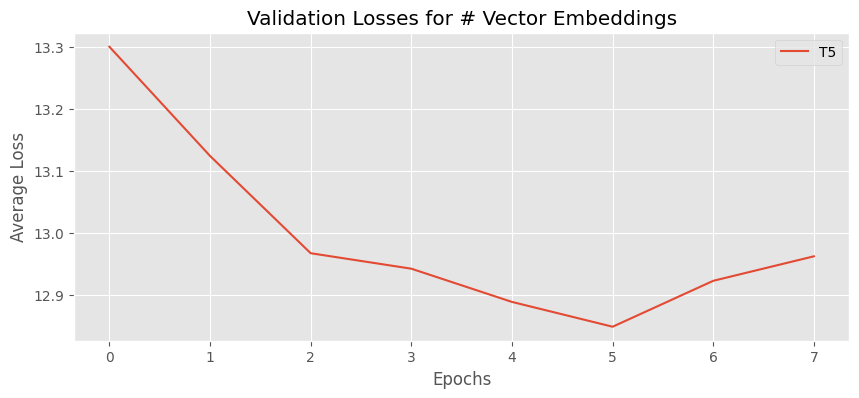

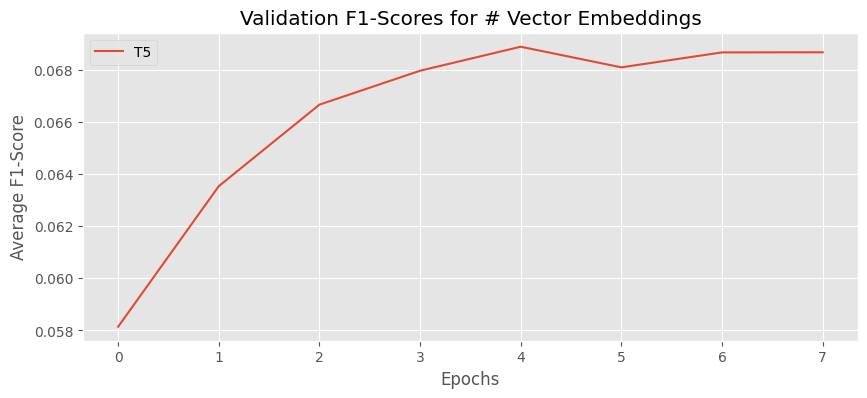

In [71]:
plt.figure(figsize = (10, 4))
#plt.plot(ems2_losses["val"], label = "EMS2")
plt.plot(t5_losses["val"], label = "T5")
#plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
#plt.plot(ems2_scores["val"], label = "EMS2")
plt.plot(t5_scores["val"], label = "T5")
#plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

## PREDICTION

In [72]:
def predict(embeddings_source):

    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = ems2_model

    model.eval()

    labels = pd.read_csv(config.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().tolist()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df


In [74]:
submission_df = predict("T5")

GENERATE PREDICTION FOR TEST SET...


224298it [02:53, 1292.32it/s]


PREDICTIONS DONE


In [75]:
len(submission_df)

112149000

<h4> SUBMISSION</h4>
You may submit this file as is.

In [77]:
submission_df.to_csv('submission.tsv', sep='\t', header=False, index=False)

In [78]:
from google.colab import files

# 1. Save the submission dataframe to a file (just to be sure it's current)
submission_df.to_csv('submission.tsv', sep='\t', header=False, index=False)

# 2. Trigger the download
files.download('submission.tsv')

KeyboardInterrupt: 

<h4> or ensemble with some other public submission

In [ ]:
#this submission was obtained by training models on BlstP and Foldseek offline
#submission2 = pd.read_csv('/kaggle/input/cafa-0322/submission.tsv',
#    sep='\t', header=None, names=['Id2', 'GO term2', 'Confidence2'])

In [ ]:
#submissions = submission2.merge(submission_df, left_on=['Id2', 'GO term2'],
#                                                  right_on=['Id', 'GO term'], how='outer')

In [ ]:
#submissions.drop(['Id', 'GO term'], axis=1, inplace=True)
#submissions['confidence_combined'] = submissions.apply(lambda row: row['Confidence2'] if not np.isnan(row['Confidence2']) else row['Confidence'], axis=1)

In [ ]:
#submissions[['Id2', 'GO term2', 'confidence_combined']].to_csv('submission.tsv', sep='\t', header=False, index=False)